In [16]:
# Import the envrionnement we need for work
import random
import anndata
import time
import os
import csv
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
#import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix
sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [17]:
def make_kfold(anndata_give,name_column,n_fold,override = False): 
    '''
    Is a function that takes an Anndata as input, and creates a new column containing a group number. Equally distributed within each cell type.

    Keyword arguments:
    anndata_give -- Choose the anndata.
    name_column -- Choose a name for the column with the fold group name
    n_fold -- Choose the nuber of fold group.
    override -- Autorise or not to overwrite a column existing and replace it by the new column (default False)
    '''

    # Check if the anndata provided is a real anndata.
    assert type(anndata_give) == anndata._core.anndata.AnnData, "Error : Type of '" + anndata_give + "' is not an anndata." 
    #Check if the name_column is a string
    assert type(name_column) == str, "Error : Column name is not a string."
    # Check whether the n_fold supplied is a int.
    assert type(n_fold) == int, "Error : Type of n_fold is incorrect. Change it to a int."
    # Autorise or not to overwrite a column already existing
    if override == False and name_column in anndata_give.obs.columns :
        print("Error : Column name exists. Activate override mode to overwrite column")
        
    # Create a new column, which only have "None" inside
    anndata_give.obs[name_column] = None 

    # Loop over the cell types to create fold groups in each of them
    for cell_type in anndata_give.obs.celltype.unique():
        # Retrieve the list of cells of the current cell type
        cell_name_list = list(anndata_give.obs.index[anndata_give.obs.celltype == cell_type])
        # Monitors whether the number of cells within the cell type is sufficient
        if len(cell_name_list) < CELL_MINIMAL_PER_TYPE_CELL :
            print("Error : Not enought cell in :", cell_type, "\nIt won't be taken into account for training and testing.")
            continue
        # Shuffle the list of cells to change their order
        random.shuffle(cell_name_list)
        # Split the list of cells into the required number of groups
        array_fold = np.array_split(np.array(cell_name_list),n_fold)
        # Assign to each fold group the index of their group
        for fold_index in range(len(array_fold)):
            anndata_give.obs.loc[array_fold[fold_index] , name_column] = fold_index

In [18]:
def run_finetuning(anndata_give, name_column, n_fold, list_type_cell=None):
    '''
    run_finetuning is a function that takes as input 1 anndata , a column and a fold number or a list of fold numbers, with a list of cell types to be excluded for the training phase.
    On output, the function provides 2 anndata, one for the test with the fold numbers chosen beforehand. And an anndata for training with the anndata not selected for the test phase and without the cell type list, if this has been supplied.
    
    Keyword arguments:
    anndata_give -- Choose the anndata.
    name_column -- Name of column with folds (group) name
    n_fold -- Provide (by a value, or a list) the folds for the test anndata
    list_type_cell -- List of cell types to be excluded from the training anndata. (default None)
    '''

    # Check if the anndata provided is a real anndata.
    assert type(anndata_give) == anndata._core.anndata.AnnData, "Error : Type of '" + anndata_give + "' is not an anndata." 
    #Check if the name_column is a string
    assert type(name_column) == str, "Error : Column name is not a string."
    # Check that the given column name exists in the anndata
    assert name_column in anndata_give.obs.columns , "Error : Column name don't exists."
    # Check whether the n_fold supplied can be read by the function.
    assert type(n_fold) == int or type(n_fold) == list , "Error : Type of n_fold is incorrect. Change it to a int or a list."
    # Check if "list_type_cell" is not none and if it's a list
    assert list_type_cell is None or type(list_type_cell) == list , "Error : " + list_type_cell + " is not a list."
 
    # Anndata creation block in case of a list.
    if type(n_fold) == list :
        # Go through the values in the list, and if one of them is not present in the column provided, display the error.
        for index in n_fold :
            assert anndata_give.obs[name_column].isin([index]).any() == True, "Error: The fold number in your list is not in " + name_column + " column."   
        # The values present in the list are scanned, separating the cells containing or not containing the fold number supplied as input. Either in the test or in the training.
        anndata_test = anndata_give[[k in n_fold for k in anndata_give.obs[name_column]]]
        # Create a new column str_batch with "1" for testing dataset to use scGPT
        anndata_test.obs["str_batch"] = "1" 
        # If no cell type list has been provided, then anndata_training returns only the groups that have not been given as input.
        if list_type_cell is None :
            anndata_training = anndata_give[[index not in n_fold for index in anndata_give.obs[name_column]]]
        # If a list of cell types has been provided, then anndata_training returns only the groups that have not been given as input and without the cell types present in the list.
        else :
            anndata_training = anndata_give[[index not in list_type_cell for index in anndata_give.obs.celltype]] and anndata_give[[index not in n_fold for index in anndata_give.obs[name_column]]]
            # Create a new column str_batch with "0" for the training dataset to use scGPT
            anndata_training.obs["str_batch"] = "0" 
            
   
    
    # Anndata creation block in case of a int.
    if type(n_fold) == int :
        # Check if the n_fold are not in colum provided, display the error.
        assert anndata_give.obs[name_column].isin([n_fold]).any() == True , "Error : The fold number is not present in " + name_column + " column."   
        # Separate the cells contain in name_column the n_fold in a new anndata name 'anndata_test' and the other in a anndata_training.
        anndata_test = anndata_give[anndata_give.obs[name_column] == n_fold]
        # Create a new column str_batch with "1" for testing dataset to use scGPT
        anndata_test.obs["str_batch"] = "1" 
        # If no cell type list has been provided, then anndata_training returns only the groups that have not been given as input.
        if list_type_cell is None :
            anndata_training = anndata_give[anndata_give.obs[name_column] != n_fold]
        # If a list of cell types has been provided, then anndata_training returns only the groups that have not been given as input and without the cell types present in the list.    
        else :
            anndata_training = anndata_give[[index not in list_type_cell for index in anndata_give.obs.celltype]] and anndata_give[anndata_give.obs[name_column] != n_fold] 
            # Create a new column str_batch with "0" for the training dataset to use scGPT
            anndata_training.obs["str_batch"] = "0" 
            
    return anndata_test, anndata_training

In [19]:
## Param for the output
# Index outpu is for giving the name of repertorie, and name of file output for the replicate data.
index_output_scGPT = 0
# Select the minimal number required in every fold for scGPT.
CELL_MINIMAL_PER_TYPE_CELL = 40

#Access for file anndata
PATH_PROJECT = "/mnt/DOSI/PLATEFORMES/BIOINFORMATIQUE/04_PROJECT/scLLM"
PATH_EXPERIMENT = os.path.join( PATH_PROJECT, "Human_Thymus_Development_Atlas")
PATH_EXPERIMENT_OUTPUT = os.path.join( PATH_EXPERIMENT, "05_Output")
PATH_EXPERIMENT_OUTPUT_ANNDATA = os.path.join( PATH_EXPERIMENT_OUTPUT, "01_Datapreprocessing")
PATH_EXPERIMENT_OUTPUT_ANNDATA_EXTRA = os.path.join(PATH_EXPERIMENT_OUTPUT_ANNDATA, "Preprocess_Anndata_File")
PATH_INPUT_FILE_ANNDATA = os.path.join( PATH_EXPERIMENT_OUTPUT_ANNDATA_EXTRA, "Human_Thymus_Development_Atlas_Preprocess.h5ad")

#Acess to the model
PATH_EXPERIMENT_REFERENCE = os.path.join( PATH_EXPERIMENT, "01_Reference")
PATH_EXPERIMENT_MODEL = os.path.join(PATH_EXPERIMENT_REFERENCE, "04_Model")
PATH_EXPERIMENT_MODEL_EXTRA = os.path.join(PATH_EXPERIMENT_MODEL, "scGPT_human")

#Access to list variable gene
PATH_EXPERIMENT_OUTPUT_VARIABLE_GENE = os.path.join( PATH_EXPERIMENT_OUTPUT, "02_GlobalHeterogenity")
PATH_INPUT_FILE_VARIABLE_GENE = os.path.join( PATH_EXPERIMENT_OUTPUT_VARIABLE_GENE, "Variable_Gene.csv")

#Output for the result
PATH_EXPERIMENT_OUTPUT_SCGPT = os.path.join( PATH_EXPERIMENT_OUTPUT, "03_scGPTAnalysis")
os.makedirs(PATH_EXPERIMENT_OUTPUT_SCGPT, exist_ok = True)

In [5]:
dataset_anndata = sc.read_h5ad(PATH_INPUT_FILE_ANNDATA)

In [20]:
# Read the variable gene file and save it as a data frame
df_variable_gene = pd.read_csv(PATH_INPUT_FILE_VARIABLE_GENE)

# Delete the column containing the numbers (which is useless in our case).
df_variable_gene = df_variable_gene.drop('Unnamed: 0', axis=1)

# Creation of a list of variable genes from the previous data frame
list_variable_gene = df_variable_gene['x'].tolist()

In [21]:
# Only genes in the list are kept in the anndata
dataset_anndata = dataset_anndata[:,[gene for gene in list_variable_gene if gene in dataset_anndata.var.index]]

#### If you want to run scGPT again to randomly change the k_folds, you must do so after this line: 

In [31]:
#Choose the number of epoch.
NUMBER_CHOICE_OF_EPOCH = 5

# Create folders where files will be saved (the two blocks are just for aesthetics)
if index_output_scGPT < 10 and any(x.startswith('run_0'+str(index_output_scGPT)) for x in os.listdir(PATH_EXPERIMENT_OUTPUT_SCGPT)) == False :
    PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT = os.path.join( PATH_EXPERIMENT_OUTPUT_SCGPT, "run_0"+ str(index_output_scGPT) + "_epoch_" + str(NUMBER_CHOICE_OF_EPOCH))
    os.makedirs(PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT)
    with open(os.path.join(PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT, 'indicators_results_annotation.csv'), 'w') as csvfile:
    # Create the column names that will be assigned in the file; they must be given in dictionary order.
        fieldnames=['accuracy', 'precision', 'recall', 'macro_f1', 'mutual_info', 'rand_index', 'k_fold']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    
if index_output_scGPT >= 10 and any(x.startswith('run_'+str(index_output_scGPT)) for x in os.listdir(PATH_EXPERIMENT_OUTPUT_SCGPT)) == False :
    PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT = os.path.join( PATH_EXPERIMENT_OUTPUT_SCGPT, "run_" + str(index_output_scGPT) + "_epoch_" + str(NUMBER_CHOICE_OF_EPOCH))
    os.makedirs(PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT)
    # Create of indicator file for current run results (to which data will then be added)
    with open(os.path.join(PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT, 'indicators_results_annotation.csv'), 'w') as csvfile:
    # Create the column names that will be assigned in the file; they must be given in dictionary order.
        fieldnames=['accuracy', 'precision', 'recall', 'macro_f1', 'mutual_info', 'rand_index', 'k_fold']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

# As long as the files exist with the previous index, you increase the index by 1. As soon as the files don't exist, you do the rest.
if any(x.startswith('run_0'+str(index_output_scGPT)) for x in os.listdir(PATH_EXPERIMENT_OUTPUT_SCGPT)):
    index_output_scGPT = index_output_scGPT + 1
                  
if any(x.startswith('run_'+str(index_output_scGPT)) for x in os.listdir(PATH_EXPERIMENT_OUTPUT_SCGPT)):
    index_output_scGPT = index_output_scGPT + 1    

In [32]:
# Select and create the number of fold of you're choice.
number_k_fold_choice = 5
make_kfold(dataset_anndata, "K_Fold", number_k_fold_choice, override = True)

In [33]:
# Create a table grouping cells by cell type and Fold
dataframe_liste_number_per_fold = pd.DataFrame([(KFold, CellType, len(c)) for (KFold, CellType), c in dataset_anndata.obs.groupby(['K_Fold', 'celltype'])]).pivot(index=1, columns=0, values=2)
dataframe_liste_number_per_fold.to_csv(os.path.join(PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT, 'dataframe_liste_number_per_fold.csv'), index=False)

## STEP 1 : Specify hyper-parameter setup for integration task

In [34]:
# Nothing to change here
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="",
    do_train=True,
    load_model=PATH_EXPERIMENT_MODEL_EXTRA,
    mask_ratio=0.0,
    epochs=NUMBER_CHOICE_OF_EPOCH,
    n_bins=51,
    MVC=False, # Masked value predicµtion for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [35]:
# You probably going to create a account to be able to launch the cells.
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

wandb: Currently logged in as: thyarion_ciml. Use `wandb login --relogin` to force relogin


{'seed': 0, 'dataset_name': '', 'do_train': True, 'load_model': '/mnt/DOSI/PLATEFORMES/BIOINFORMATIQUE/04_PROJECT/scLLM/Human_Thymus_Development_Atlas/01_Reference/04_Model/scGPT_human', 'mask_ratio': 0.0, 'epochs': 5, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


## STEP 2 : RUN scGPT

Global seed set to 0


----------------------------------------
New run on a k_fold (Number : 0) started.
----------------------------------------
save to /mnt/DOSI/PLATEFORMES/BIOINFORMATIQUE/04_PROJECT/scLLM/Human_Thymus_Development_Atlas/05_Output/03_scGPTAnalysis/run_08/K_Fold_0
scGPT - INFO - match 1993/1993 genes in vocabulary of size 60697.
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
random masking at epoch   1, ratio of masked values in train:  0.0000
scGPT - INFO - | epoch   1 | 100/5757 batches | lr 0.0001 | ms/batch 224.06 | loss  1.92 | cls  1.92 | err  0.56 | 
scGPT - INFO - | epoch   1 | 200/5757 batches | lr 0.0001 | ms/batch 183.14 | loss  1.12 | cls  1.12 | err  0.37 | 
scGPT - INFO - | epoch   1 | 300/5757 batches | lr 0.0001 | ms/batch 183.93 | loss  0.85 | cls  0.85 | err  0.28 | 
scGPT - INFO - | epoch   1 | 400/5757 batches | lr 0.0001 | ms/batch 184.98 | loss  0.74 | cls  0.74 | 

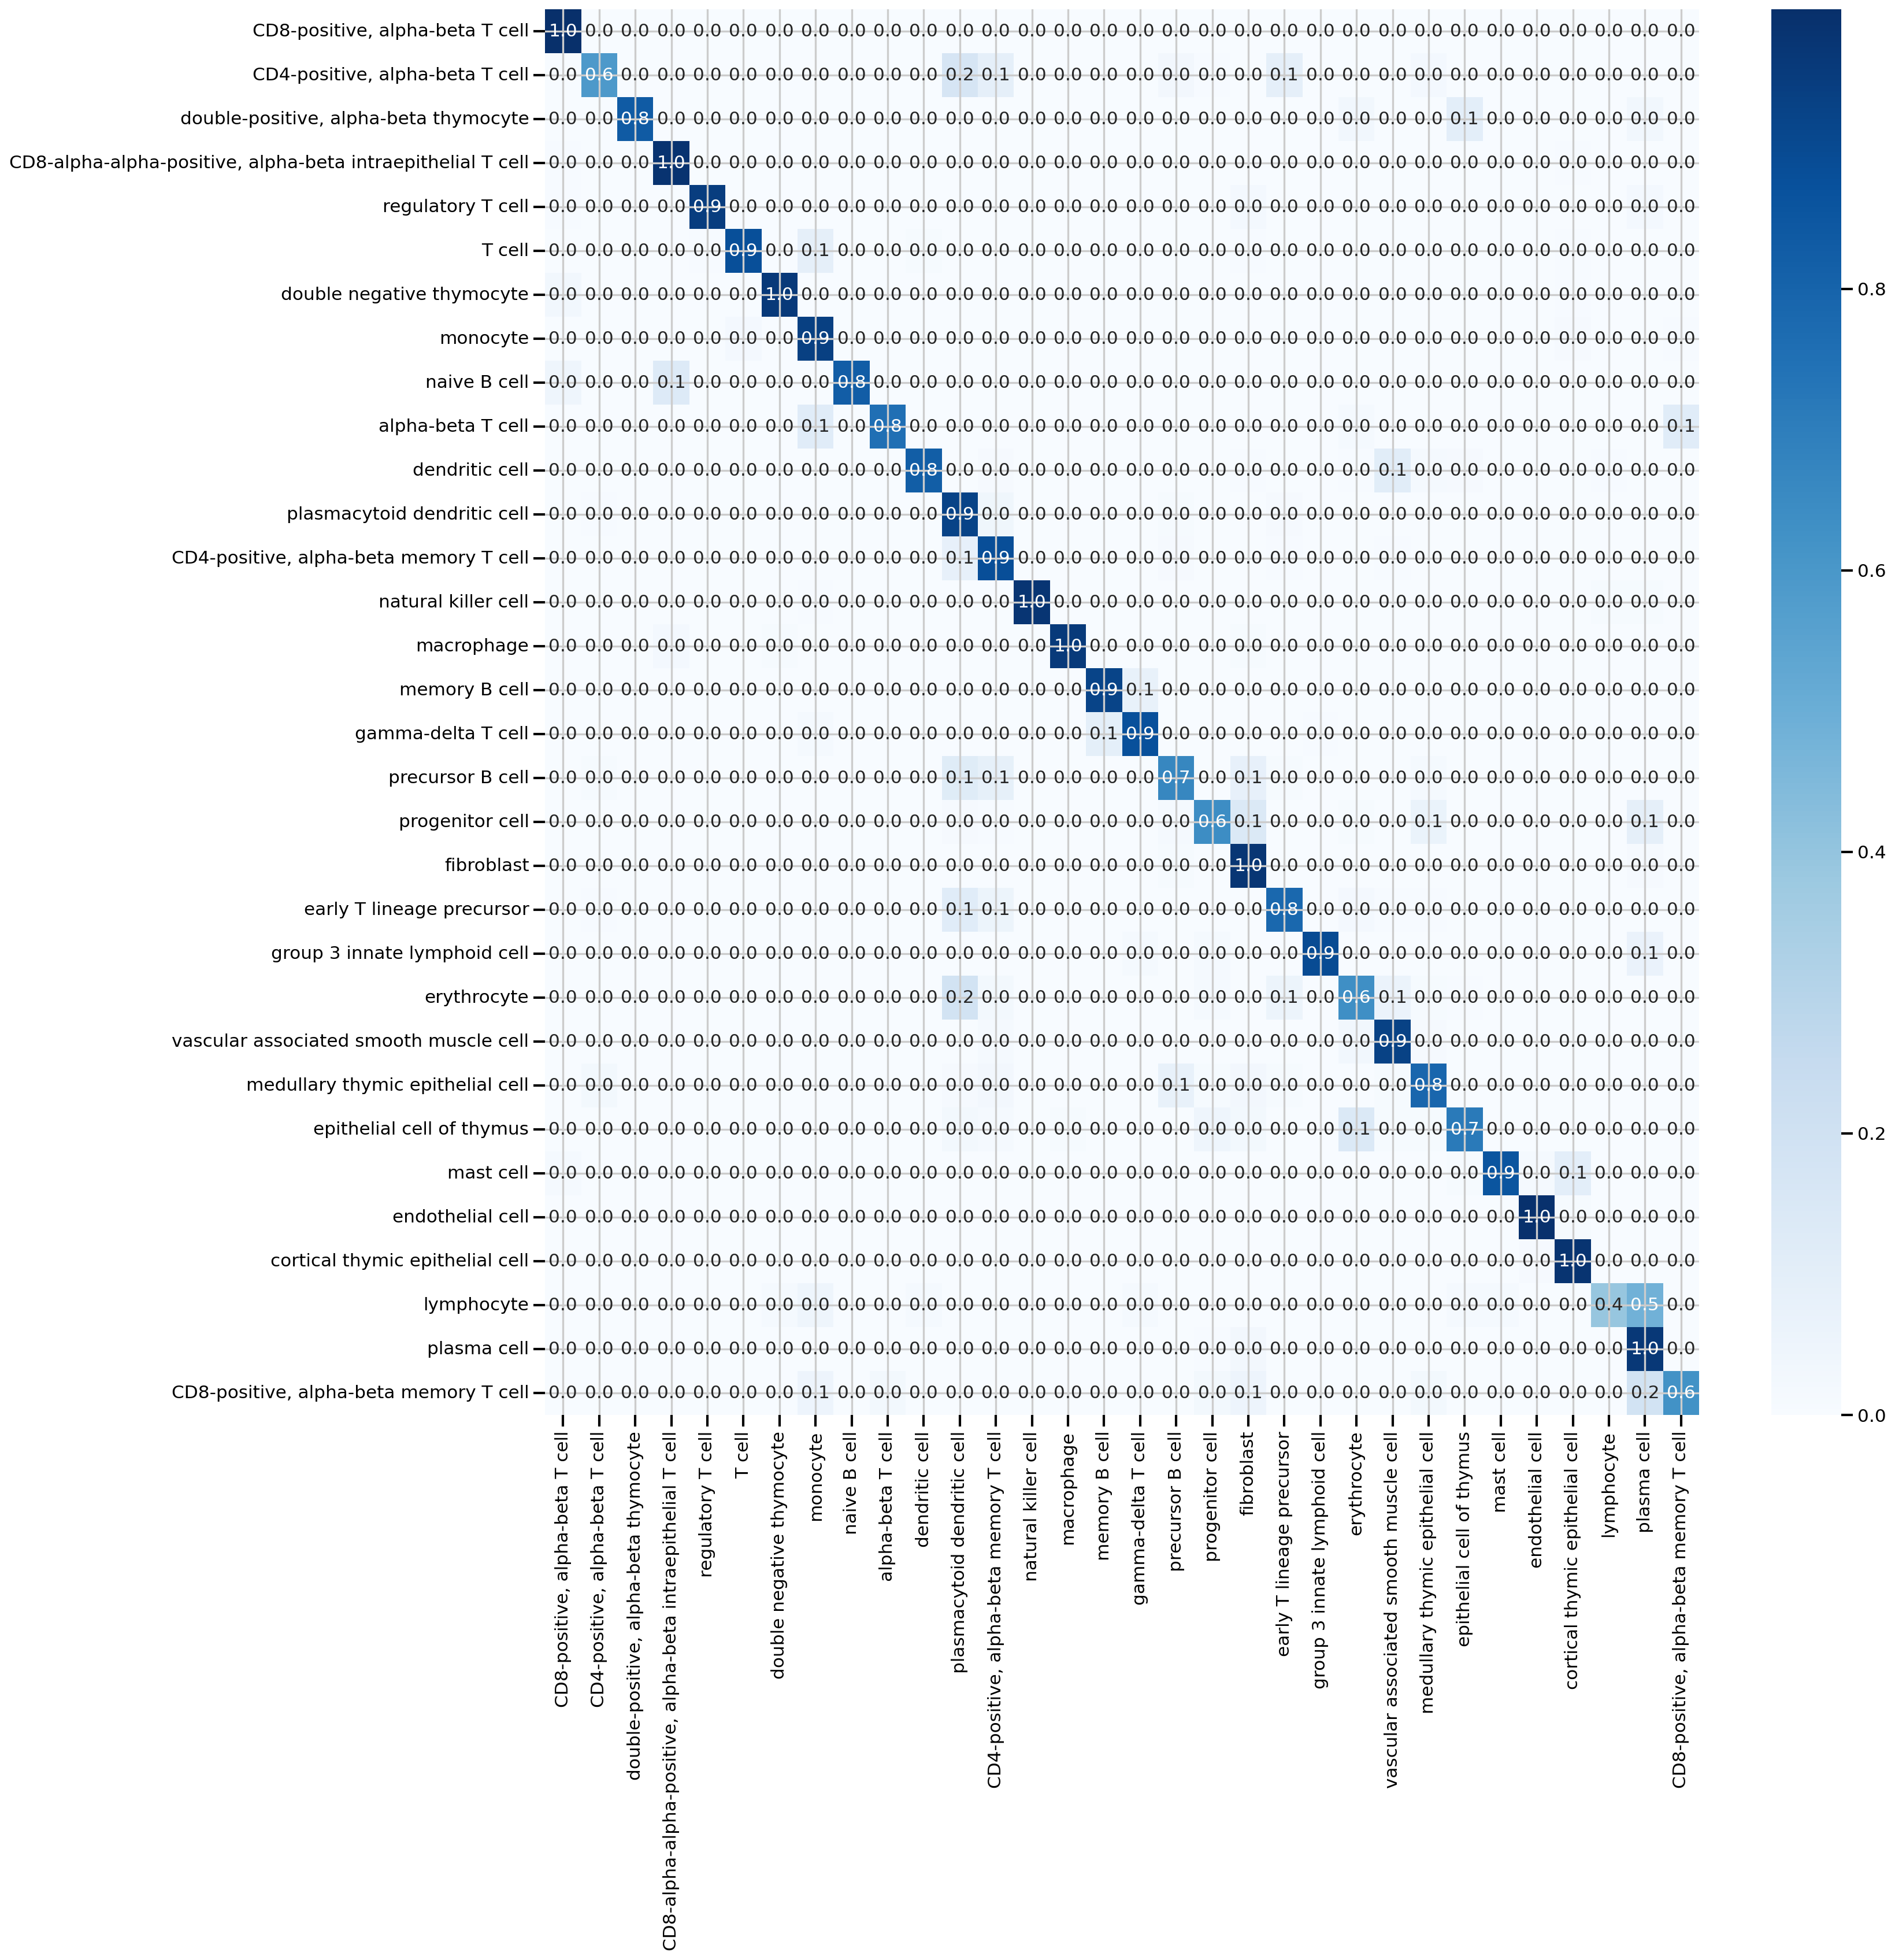

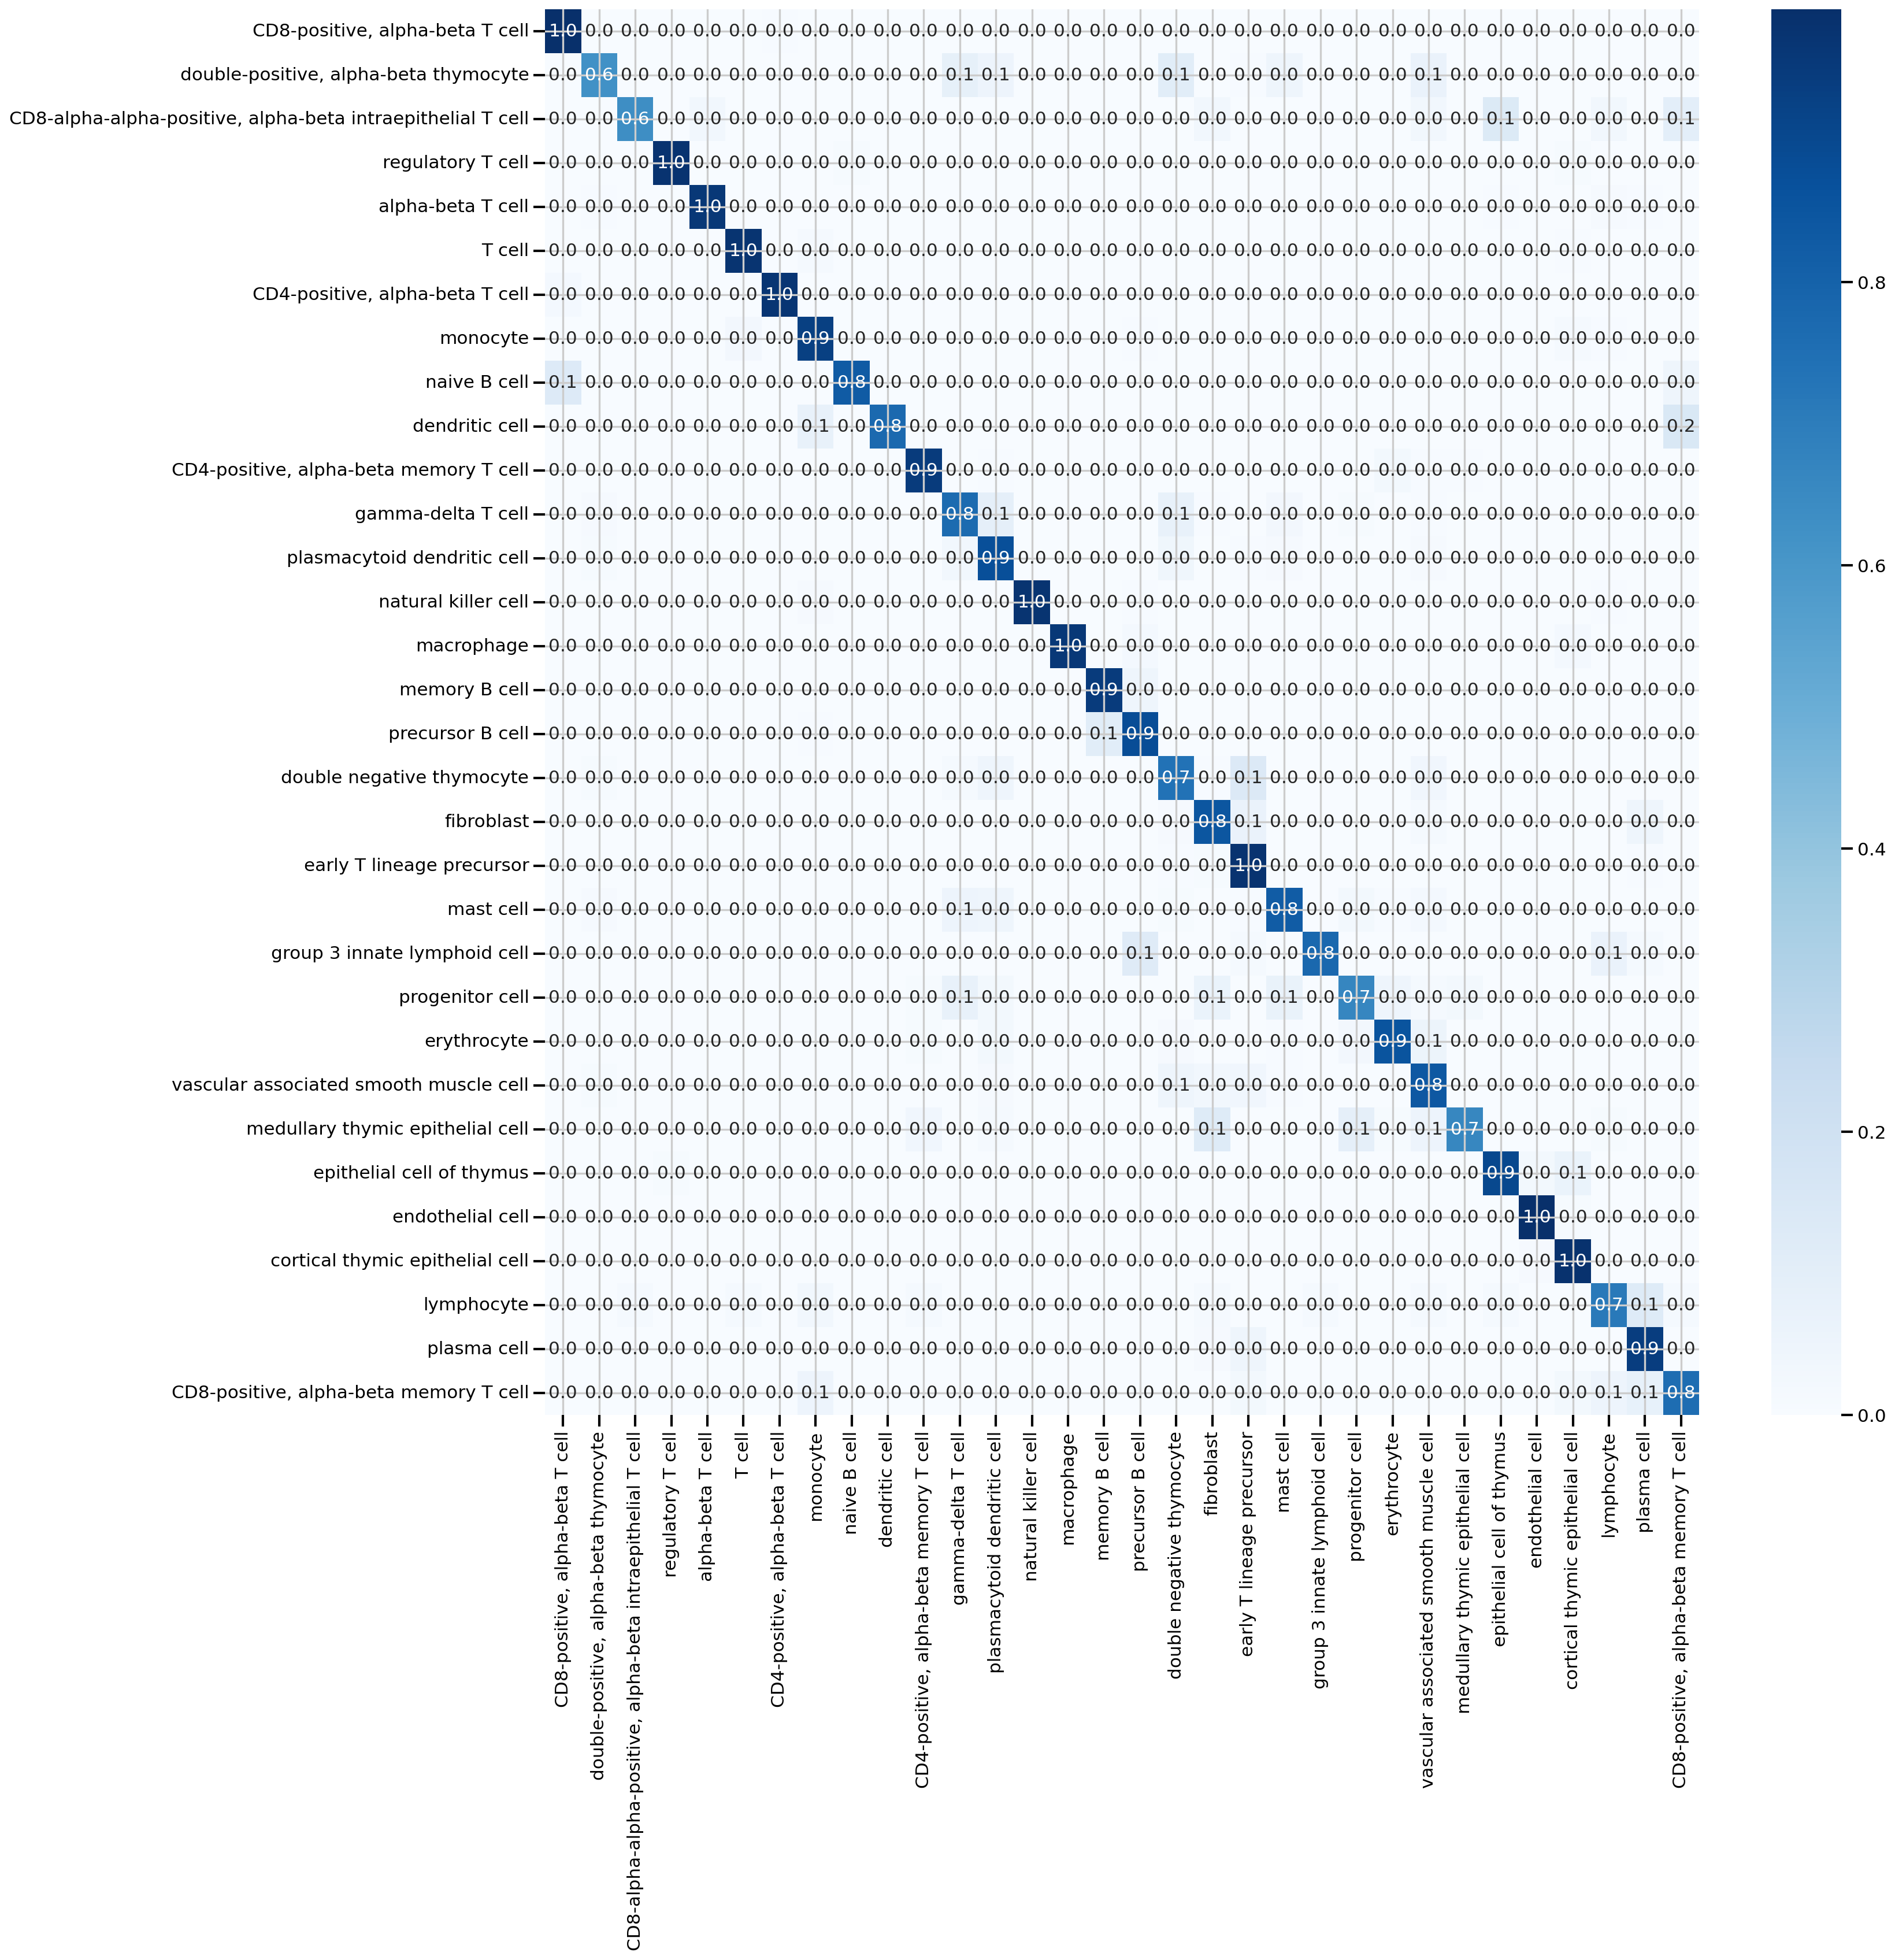

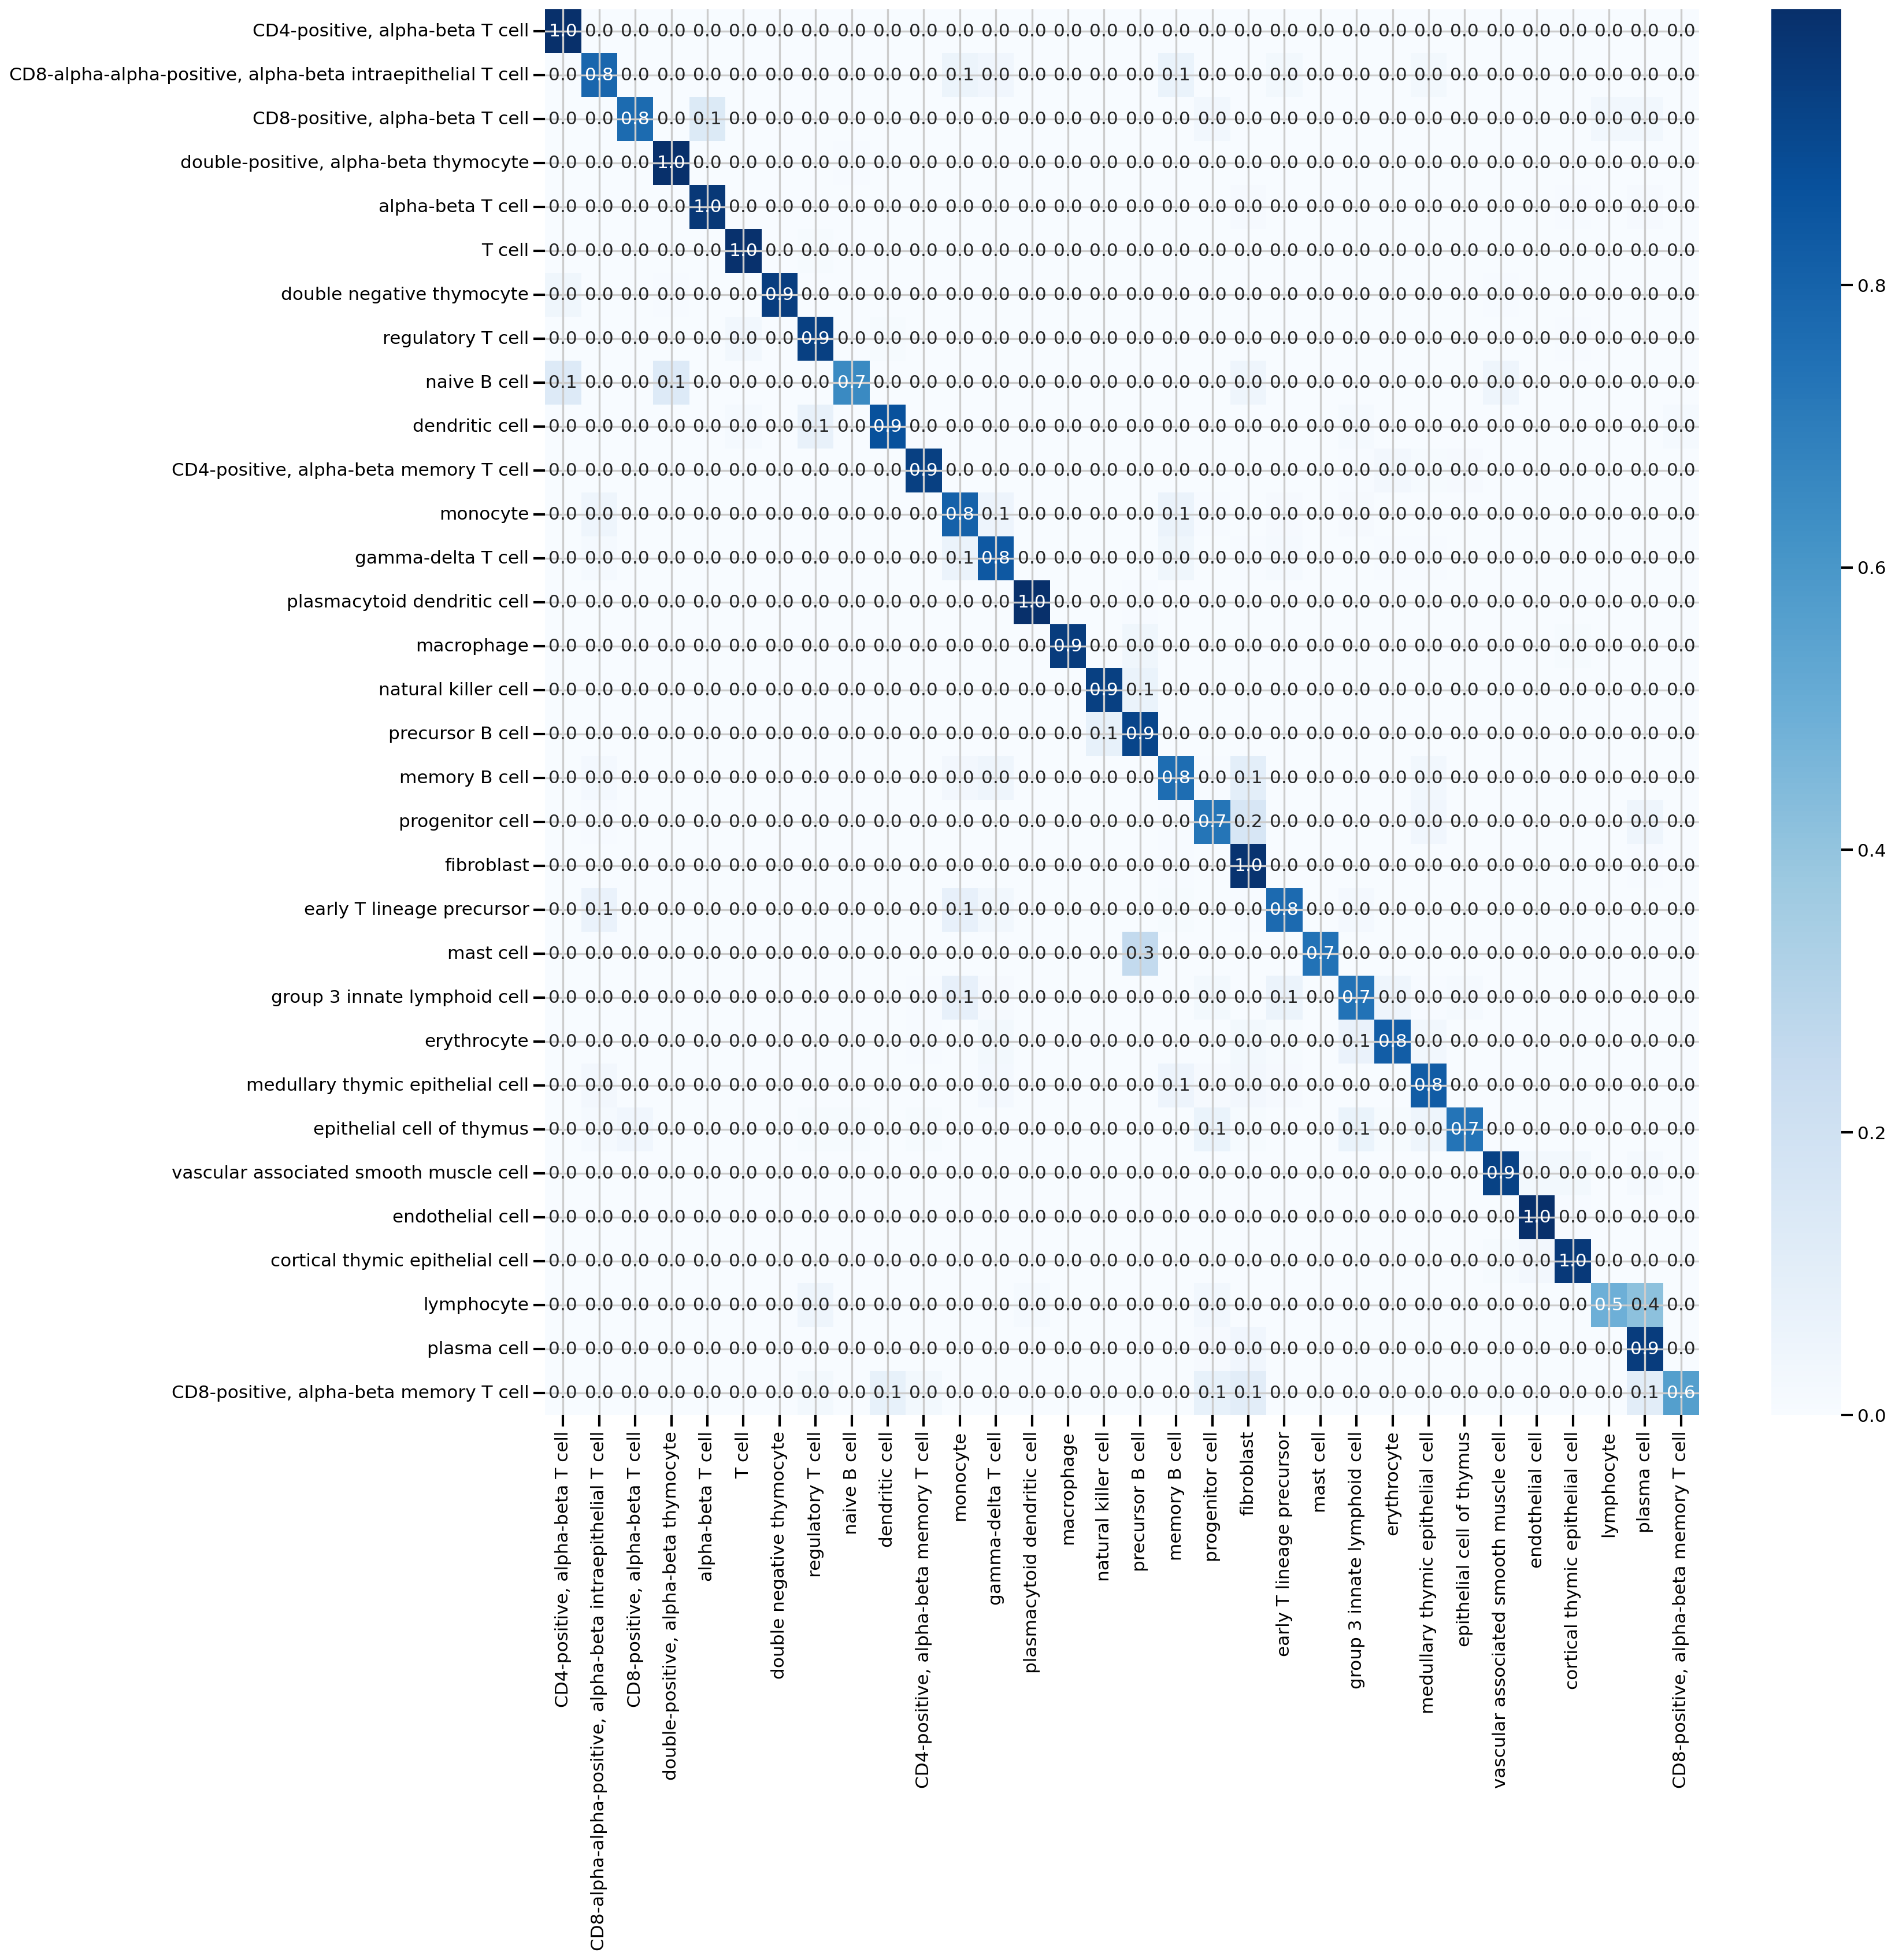

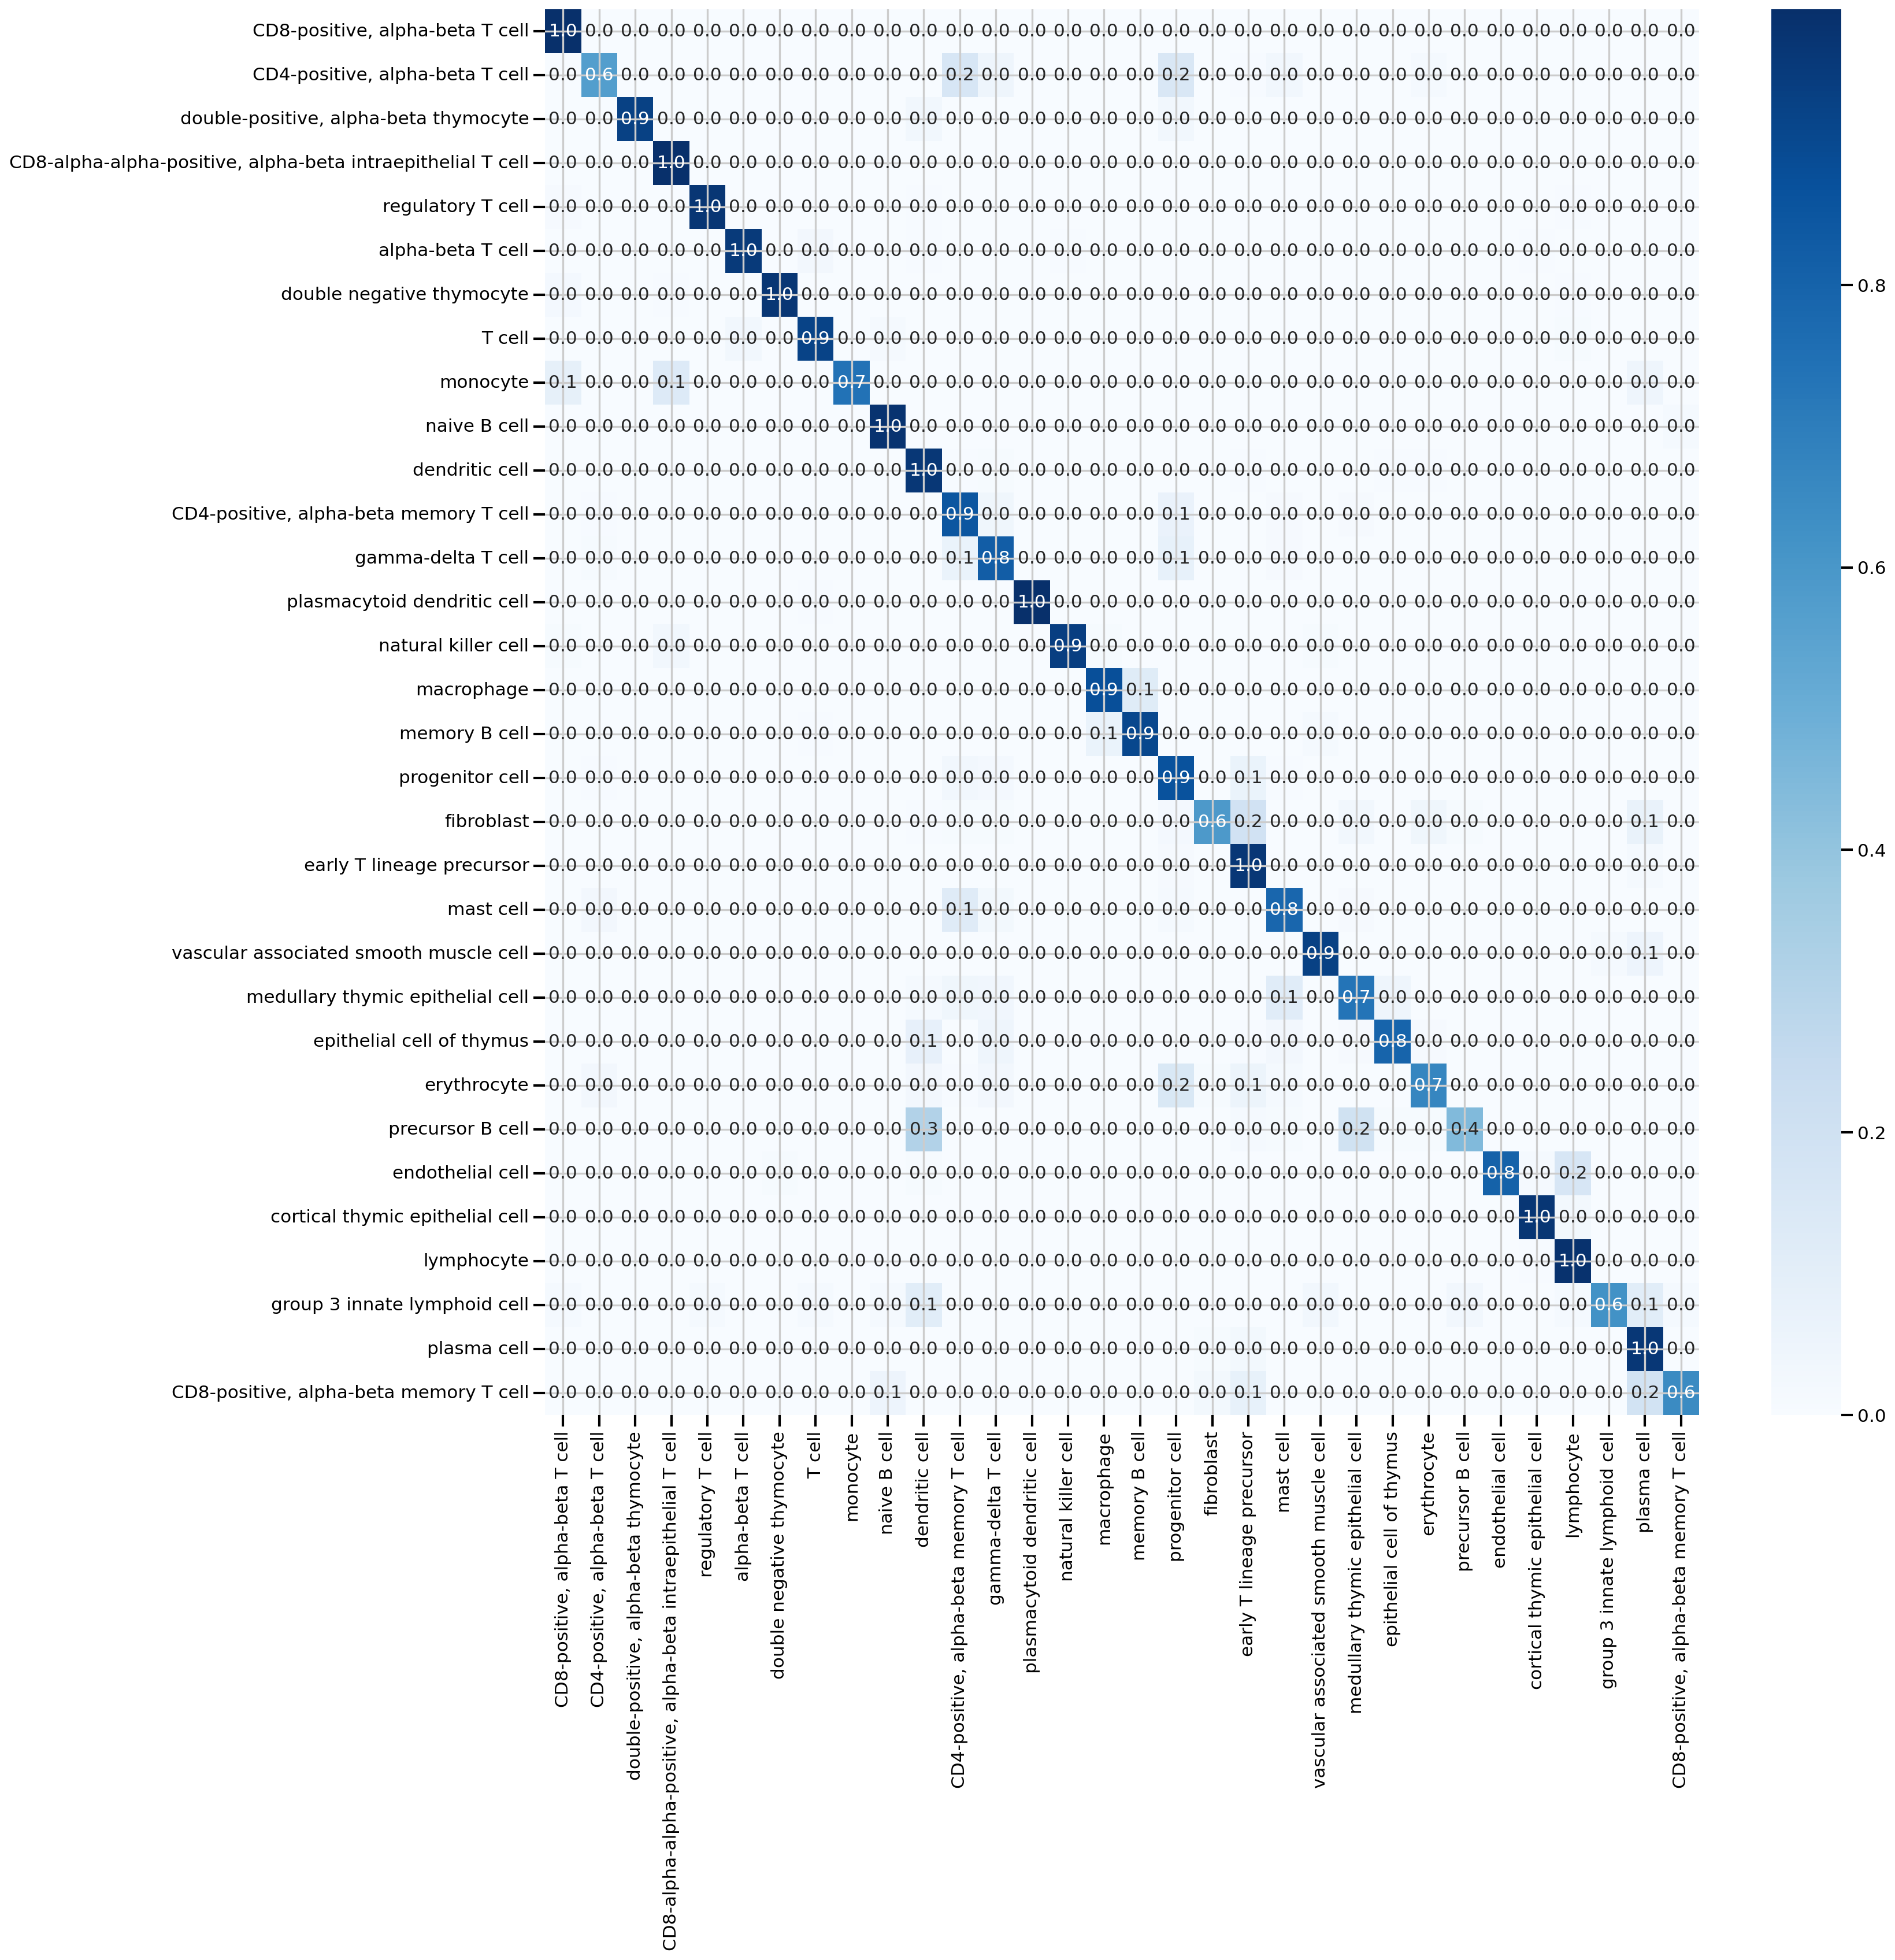

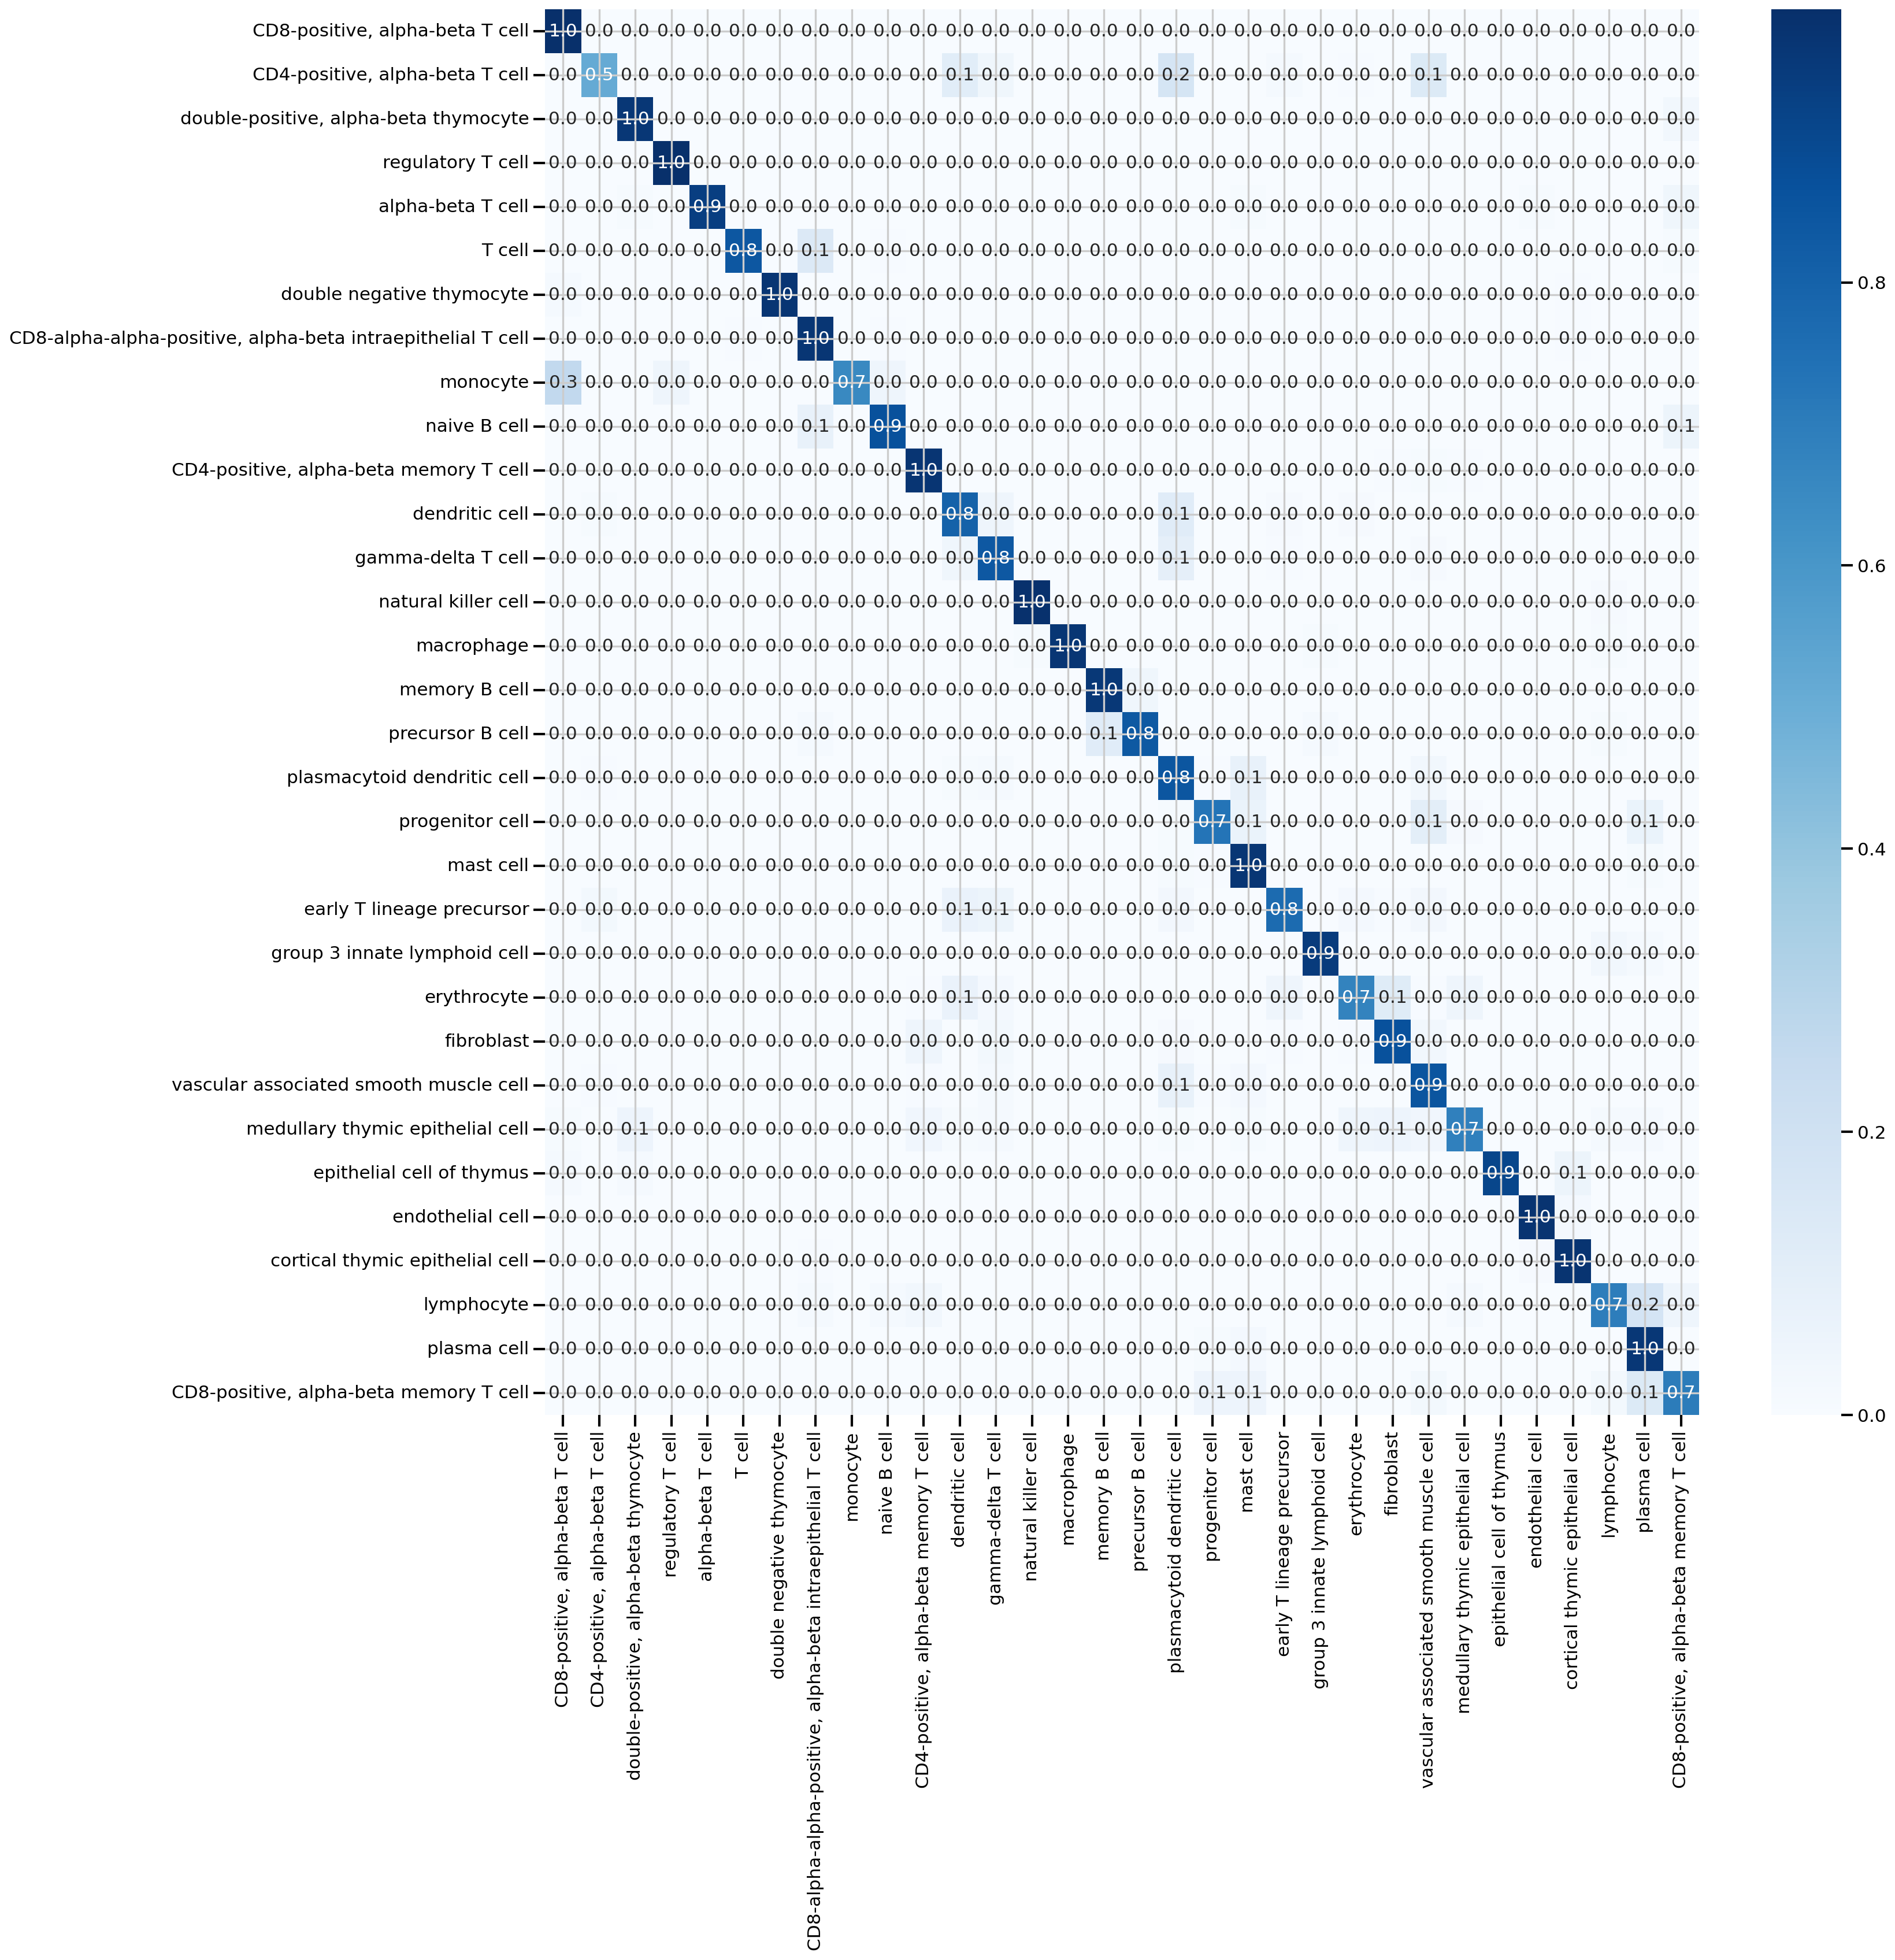

In [36]:
# If verbose is set to True, the code will be traceable
verbose = False

# Loop for to allow scGPT to run with the number of epochs provided above on the selected fold set.
for index_number_kfold in range (number_k_fold_choice) :
    liste_number_kfold = []
    liste_number_kfold.append(index_number_kfold)

    # That will create repertory with different name
    PATH_EXPERIMENT_EXTRA_KFOLD_OUTPUT_SCGPT = os.path.join( PATH_EXPERIMENT_EXTRA_OUTPUT_SCGPT, "K_Fold_" + str(index_number_kfold))
    os.makedirs(PATH_EXPERIMENT_EXTRA_KFOLD_OUTPUT_SCGPT)
    
    adata_test, adata = run_finetuning(dataset_anndata, "K_Fold", liste_number_kfold)

    %run -i scGPT_fonctionnement.py